<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>


# Introduction

The aim of this workbook is to use unsupervised learning to draw insights from a dataset.

## Lib Imports

In [31]:
import torch
from torch import nn
from tqdm.auto import tqdm
from dataclasses import dataclass
from torchvision import transforms, datasets
from torchvision.models import inception_v3
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
torch.autograd.set_detect_anomaly(True)

In [3]:
torch.cuda.is_available()

True

### Helper Methods


In [4]:
class Generator(nn.Module):
    def __init__(self,
                 input_dim=10,
                 input_channel=1,
                 hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.generator = nn.Sequential(
            self._make_gen_block(input_dim, hidden_dim * 4),
            self._make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self._make_gen_block(hidden_dim * 2, hidden_dim),
            self._make_gen_block(hidden_dim, input_channel, kernel_size=4, final_layer=True)
        )

    def _make_gen_block(self,
                        input_channels: int,
                        output_channels: int,
                        kernel_size=3,
                        stride=2,
                        final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.generator(x)

In [5]:
def get_noise(n_samples, input_dim, device="cpu"):
    return torch.randn(n_samples, input_dim, device=device)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_channel=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._make_disc_block(image_channel, hidden_dim),
            self._make_disc_block(hidden_dim, hidden_dim * 2),
            self._make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )

    def _make_disc_block(self,
                         input_channels: int,
                         output_channels: int,
                         kernel_size=4,
                         stride=2,
                         final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, input):
        disc_pred = self.disc(input)
        return disc_pred.view(len(disc_pred), -1)

### Combined Vectors method

In [7]:
def combine_vectors(x, y):
    return torch.cat([x.float(), y.float()], axis=1)

In [8]:
if torch.cuda.is_available():
    cuda_check = combine_vectors(
        torch.tensor([[1, 2], [3, 4]]).cuda(),
        torch.tensor([[5, 6], [7, 8]]).cuda()
    )
    assert(str(cuda_check.device)).startswith("cuda")

combined = combine_vectors(
    torch.tensor([[1, 2], [3, 4]]).cuda(),
    torch.tensor([[5, 6], [7, 8]]).cuda()
)
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]], device="cuda", dtype=float))
assert (type(combined[0][0].item()) == float)

combined2 = combine_vectors(
    torch.randn(1, 4, 5),
    torch.randn(1, 8, 5)
)
assert tuple(combined2.shape) == (1, 12, 5)

### Get One Hot Labels Method

In [9]:
def get_one_hot_labels(labels, n_classes):
    return nn.functional.one_hot(labels, n_classes)

In [10]:
one_hot_labels = get_one_hot_labels(
    labels=torch.Tensor([[0, 2, 1]]).long(),
    n_classes=3
)
assert one_hot_labels.tolist() == [[
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
]]

if torch.cuda.is_available():
    cuda_one_hot_labels = get_one_hot_labels(
        torch.Tensor([[0]]).long().cuda(),
        1
    )
    assert str(cuda_one_hot_labels.device).startswith("cuda")

### Get Input Dimension Custom Method

In [11]:
@dataclass
class InputDimensions:
    generator_input_dim: int
    discriminator_image_channels: int


def get_input_dimensions(z_dim: int, mnist_shape: tuple[int], n_classes: int) -> InputDimensions:
    generator_input_dim = z_dim + n_classes
    discriminator_image_channels = mnist_shape[0] + n_classes

    return InputDimensions(
        generator_input_dim=generator_input_dim,
        discriminator_image_channels=discriminator_image_channels
    )

In [12]:
input_dimensions = get_input_dimensions(
    z_dim=23,
    mnist_shape=(12, 23, 52),
    n_classes=9
    )

assert input_dimensions.generator_input_dim == 32
assert input_dimensions.discriminator_image_channels == 21

### Hyperparameters

In [13]:
BATCH_SIZE = 128
Z_DIM = 64
IMAGE_SIZE = 28 * 28
NOISE_DIM = 100
NUM_CLASSES = 10
MNIST_SHAPE = (1, 28, 28)
NUM_EPOCHS = 20
LEARNING_RATE = 0.0002
DISPLAY_STEP = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Data Loading and EDA

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [15]:
mnist = datasets.MNIST(
    root="./gan_data",
    train=True,
    transform=transform,
    download=True
)

In [16]:
data_loader = DataLoader(
    mnist,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [17]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

In [18]:
images.shape

torch.Size([128, 1, 28, 28])

In [19]:
labels

tensor([6, 9, 5, 3, 3, 1, 9, 3, 7, 2, 8, 4, 3, 2, 0, 9, 7, 2, 2, 8, 4, 4, 8, 8,
        1, 0, 8, 7, 7, 7, 6, 6, 2, 2, 2, 0, 7, 5, 7, 2, 6, 4, 0, 0, 4, 2, 4, 6,
        5, 7, 6, 1, 1, 8, 8, 4, 1, 3, 5, 2, 8, 1, 8, 1, 4, 6, 0, 5, 8, 1, 6, 9,
        9, 1, 4, 6, 7, 3, 2, 7, 6, 4, 1, 8, 1, 9, 6, 1, 7, 4, 4, 3, 2, 5, 9, 9,
        8, 1, 5, 3, 4, 3, 8, 5, 7, 6, 0, 8, 3, 9, 9, 6, 1, 7, 9, 0, 7, 0, 6, 6,
        3, 8, 0, 5, 3, 5, 3, 2])

In [20]:
first_image = images[0].squeeze().numpy()
first_label = labels[0].item()

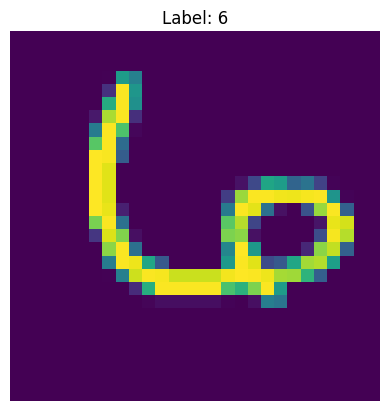

In [21]:
plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

### 2. Model Training

Input Dimensions

In [22]:
input_dimensions = get_input_dimensions(
    z_dim=Z_DIM,
    mnist_shape=MNIST_SHAPE,
    n_classes=NUM_CLASSES
)


Generator and Generator Optimizer Definition

In [23]:
generator = Generator(
    input_dim=input_dimensions.generator_input_dim
).to(device=DEVICE)

generator_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=LEARNING_RATE
)

Discriminator and Discriminator Optimizer Definition

In [24]:
discriminator = Discriminator(
    image_channel=input_dimensions.discriminator_image_channels
).to(DEVICE)

disciminator_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=LEARNING_RATE
)

  0%|          | 0/469 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 4.024316776275635, discriminator loss: 0.035370662942528726


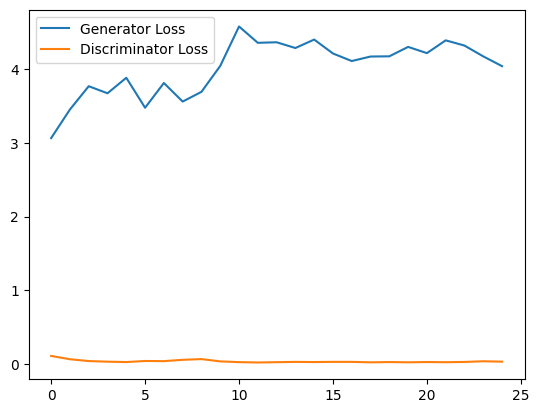

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 4.70616066646576, discriminator loss: 0.02630133953411132


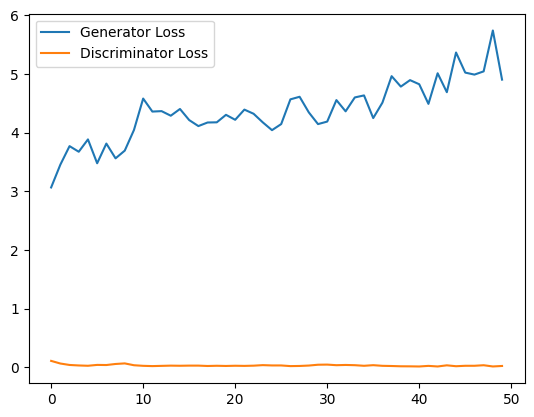

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 5.044970029354095, discriminator loss: 0.026698841472156346


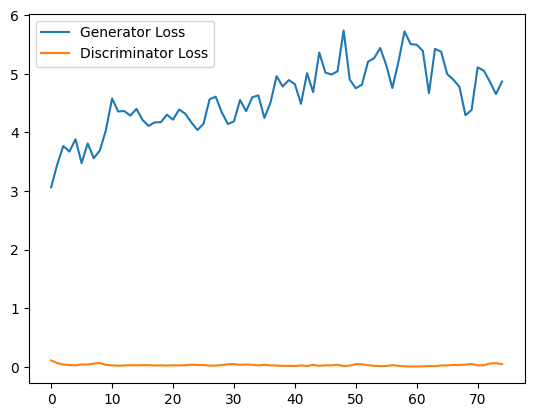

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 4.3664939227104185, discriminator loss: 0.07382082551345229


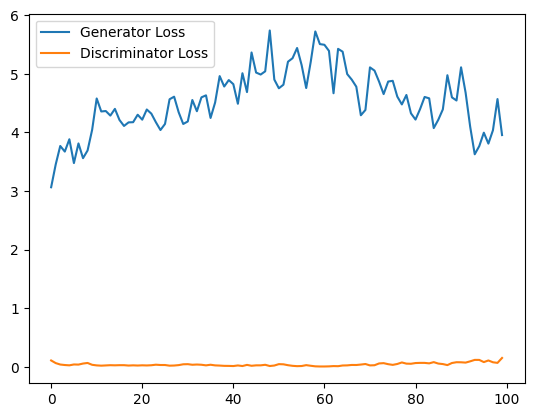

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 3.4817469396591187, discriminator loss: 0.15747813346236944


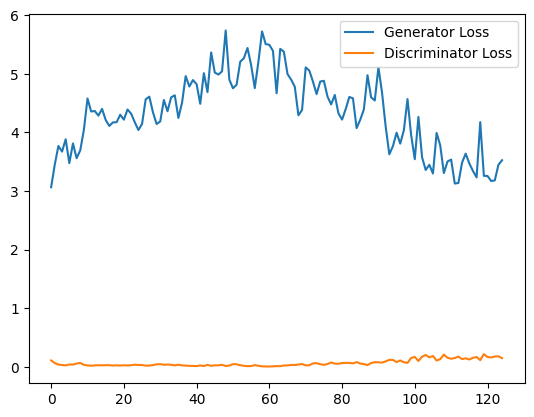

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 3.0246312849521635, discriminator loss: 0.20554750438034536


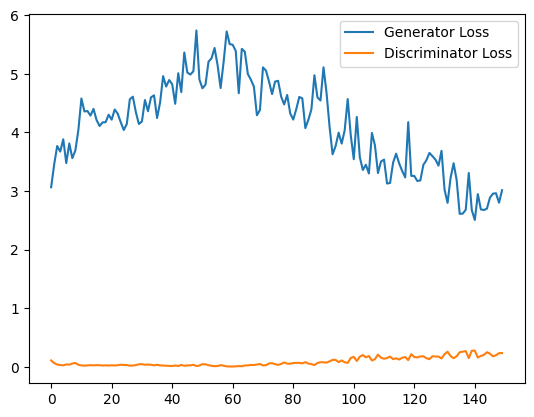

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.710434808969498, discriminator loss: 0.2822777817249298


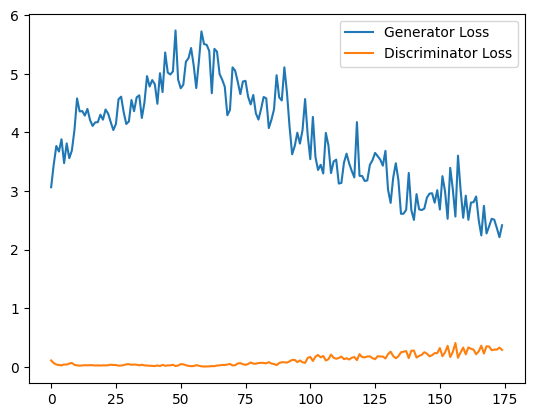

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 2.4062374057769778, discriminator loss: 0.308739589869976


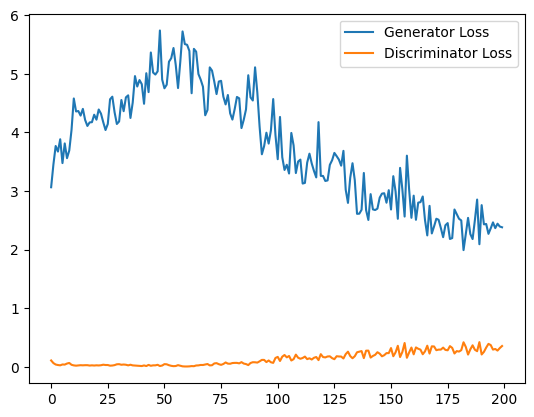

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 2.2910570611953736, discriminator loss: 0.33124116230010986


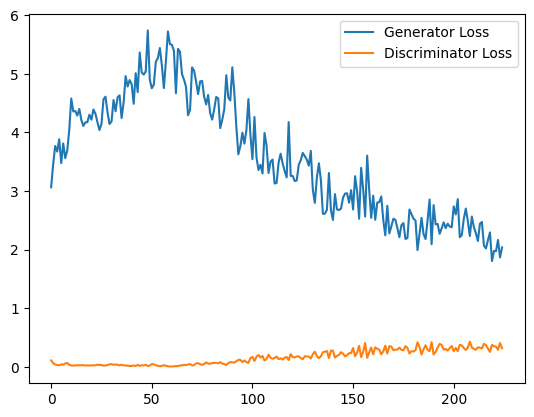

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 2.0462400302886965, discriminator loss: 0.336557521879673


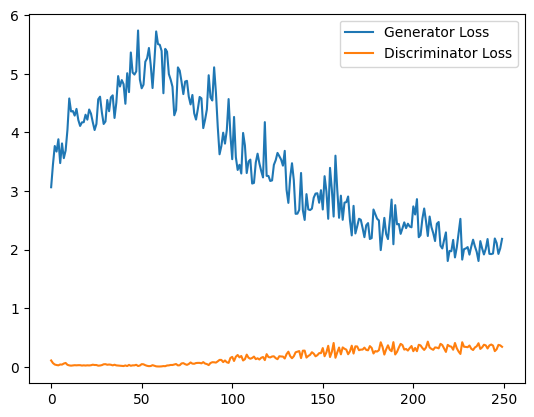

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 1.8957123606204986, discriminator loss: 0.37744541120529174


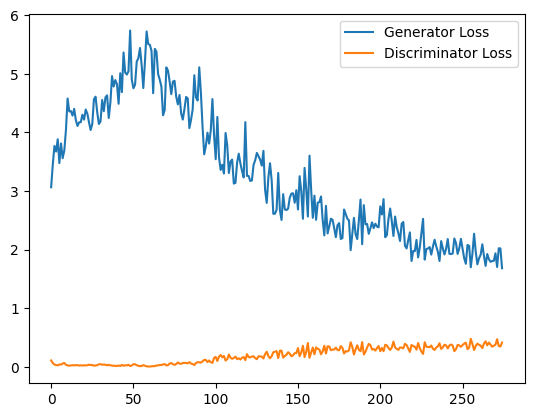

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.7595917239189147, discriminator loss: 0.4123953235447407


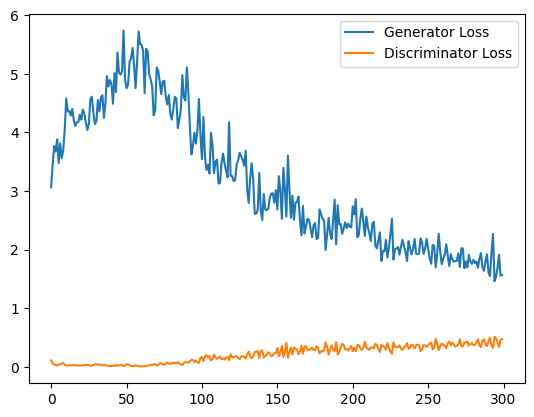

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.5924082617759705, discriminator loss: 0.440760053217411


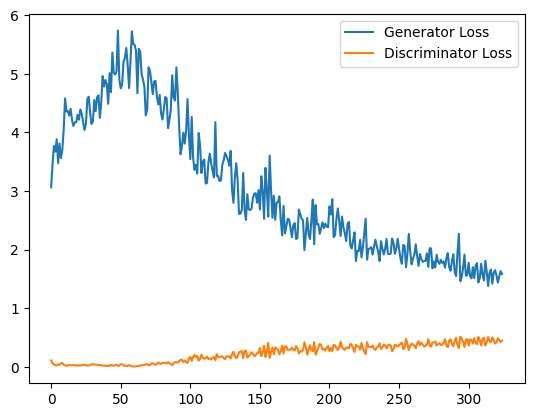

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.5335501676797867, discriminator loss: 0.48743730515241623


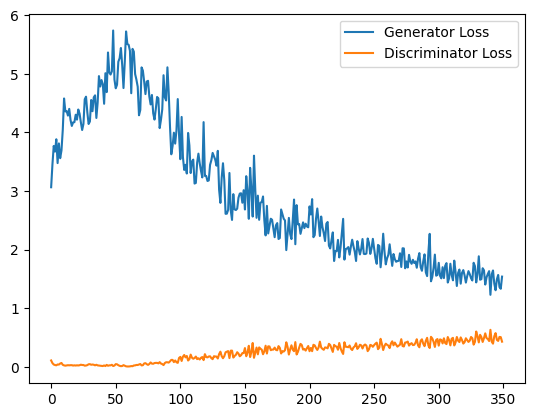

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.4264161114692688, discriminator loss: 0.519616129219532


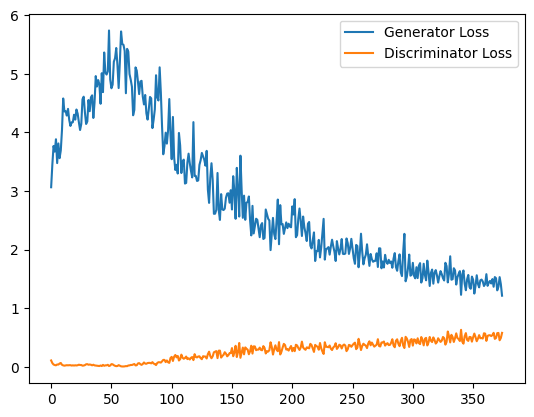

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.2528060677051545, discriminator loss: 0.5269711681008339


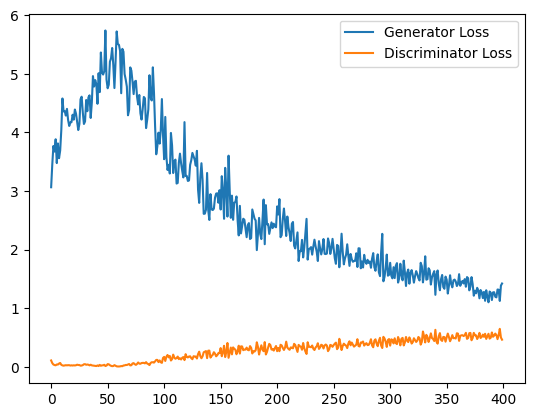

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.324950027346611, discriminator loss: 0.5562811565995216


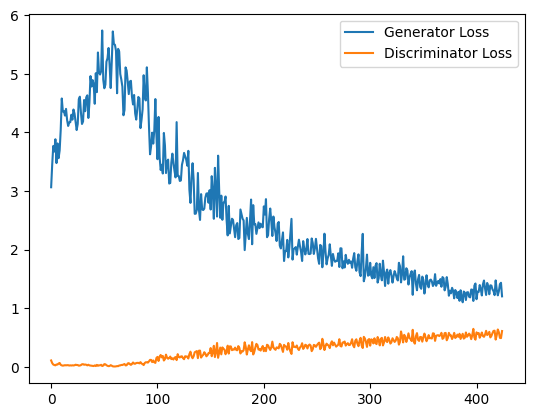

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 1.249882155895233, discriminator loss: 0.5687996485829353


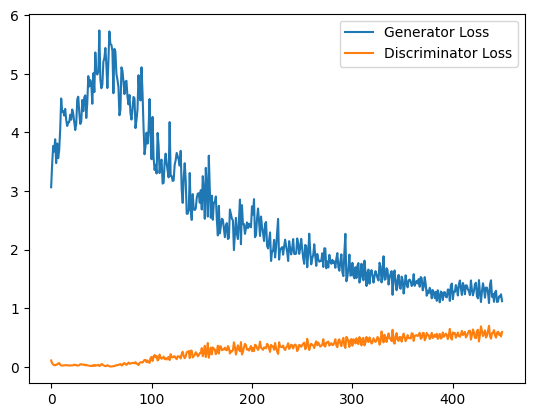

In [27]:
cur_step = 0
generator_losses = []
discriminator_losses = []
CRITERION = nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    for real_images, labels in tqdm(data_loader):
        cur_batch_size = len(real_images)
        real_images = real_images.to(DEVICE)

        one_hot_labels = get_one_hot_labels(labels.to(DEVICE), NUM_CLASSES)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, MNIST_SHAPE[1], MNIST_SHAPE[2])

        disciminator_optimizer.zero_grad()
    
        fake_noise = get_noise(
            cur_batch_size,
            Z_DIM,
            device=DEVICE
        )

        noise_and_labels = combine_vectors(
            fake_noise,
            one_hot_labels
        )

        fake_images = generator(noise_and_labels)

        assert len(fake_images) == len(real_images)
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        assert tuple(fake_images.shape) == (len(real_images), 1, 28, 28)

        # Discriminator
        fake_image_and_labels = combine_vectors(
            fake_images.detach(),
            image_one_hot_labels
        )
        real_image_and_labels = combine_vectors(
            real_images.detach(),
            image_one_hot_labels
        )
        discriminator_fake_pred = discriminator(fake_image_and_labels)
        discriminator_real_pred = discriminator(real_image_and_labels)

        assert tuple(fake_image_and_labels.shape) == (len(real_images), fake_images.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real_images), real_images.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(discriminator_real_pred) == len(real_images)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(discriminator_fake_pred.shape) == tuple(discriminator_real_pred.shape)

        discriminator_fake_loss = CRITERION(discriminator_fake_pred, torch.zeros_like(discriminator_fake_pred))
        discriminator_real_loss = CRITERION(discriminator_real_pred, torch.ones_like(discriminator_real_pred))
        discriminator_loss = (discriminator_fake_loss + discriminator_real_loss) / 2
        discriminator_loss.backward(retain_graph=True)
        disciminator_optimizer.step()

        discriminator_losses += [discriminator_loss.item()]

        generator_optimizer.zero_grad()
        fake_image_and_labels = combine_vectors(fake_images, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        discriminator_fake_pred = discriminator(fake_image_and_labels)
        generator_loss = CRITERION(discriminator_fake_pred, torch.ones_like(discriminator_fake_pred))
        generator_loss.backward()
        generator_optimizer.step()
    
        generator_losses += [generator_loss.item()]
        
        if cur_step % DISPLAY_STEP == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-DISPLAY_STEP:]) / DISPLAY_STEP
            disc_mean = sum(discriminator_losses[-DISPLAY_STEP:]) / DISPLAY_STEP
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            # show_tensor_images(fake)
            # show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

### Model Evaluation

In [28]:
generator = generator.eval()

In [29]:
torch.save(generator.state_dict(), "conditional_GAN.pth")

In [40]:
def compute_inception_score(
        generator,
        noise_dim: int,
        num_classes: int,
        num_samples=1000,
        batch_size=64,
        device="cuda"
):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    generator.eval()
    preds = []

    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            noise = get_noise(
                n_samples=num_samples,
                input_dim=batch_size,
                device=device
            )
            noise_and_labels = combine_vectors(noise, labels)
            fake_images = generator(noise_and_labels).view(-1, 1, 28, 28)
            fake_images = nn.functional.interpolate(fake_images.repeat(1, 3, 1, 1), size=(299, 299), mode='bilinear')
            prediction = nn.functional.softmax(model(fake_images), dim=1)
            preds.append(prediction.cpu())

    preds = torch.cat(preds, dim=0).numpy()

    kl_div = preds * (np.log(preds) - np.log(preds.mean(axis=0, keepdims=True)))
    inception_score = np.exp(kl_div.sum(axis=1)).mean()
    return inception_score


In [41]:
inception_score = compute_inception_score(
    generator=generator,
    noise_dim=NOISE_DIM,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    num_samples=1000,
    device=DEVICE
)

/home/mbarbaric/dev/ai/IBM_Machine_Learning_Certificate/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mbarbaric/dev/ai/IBM_Machine_Learning_Certificate/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [42]:
noise = get_noise(
    n_samples=1000,
    input_dim=BATCH_SIZE,
    device=DEVICE
)
noise.shape

torch.Size([1000, 128])

In [43]:
labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,)).to(DEVICE)
labels.shape

torch.Size([128])

In [44]:
first_label = get_one_hot_labels(torch.Tensor([1]).long(), NUM_CLASSES)
first_label.shape

torch.Size([1, 10])

In [45]:
first_label_test = first_label[:, :, None, None]
first_label_test.shape

torch.Size([1, 10, 1, 1])

In [46]:
first_label_test2 = first_label_test.repeat(1, 1, MNIST_SHAPE[1], MNIST_SHAPE[2])
first_label_test2.shape

torch.Size([1, 10, 28, 28])

In [ ]:
print(f"inception_score: {inception_score}")